In [1]:
import os
import csv
import random
import numpy as np
from PIL import Image as PIL_Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.autograd import Variable

from torchvision import transforms

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
seed = 400

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)    
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
print(device)

cuda


In [4]:
image_path = "../imgs/"
label_path = "../csvs/"

In [5]:
seq_size = 20

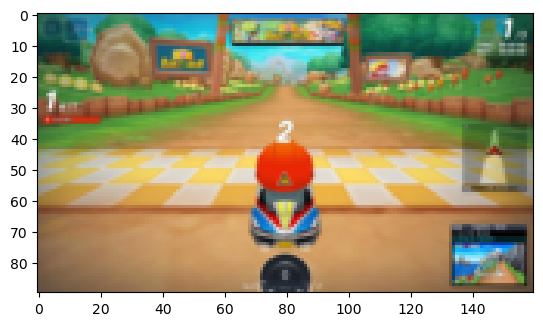

In [6]:
preprocess = transforms.Compose([
    transforms.Resize((90, 160)),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 3, 10, 1080, 1920
a = PIL_Image.open("../imgs/0/10.jpg")
a = preprocess(a)
a = a.swapaxes(0, 1)
a = a.swapaxes(1, 2)
plt.imshow(a)

In [7]:
# str_to_label = {
#     "100000" : 0,
#     "101000" : 1,
#     "110000" : 2,
#     "101010" : 3,
#     "000000" : 4,
#     "010000" : 5,
#     "111000" : 6,
#     "001000" : 7,
#     "100100" : 8,
#     "110010" : 9,
#     "110100" : 10,
#     "101100" : 11,
#     "011000" : 12,
# }

str_to_label = {
    "10000" : 0,
    "11000" : 1,
    "10100" : 2,
    "10101" : 3,
    "00000" : 4,
    "10010" : 5,
    "01000" : 6,
    "11100" : 7,
    "00100" : 8,
    "11001" : 9,
    "01100" : 10,
    "10110" : 11,
    "11010" : 12,
}

label_to_str = {}
for k, v in str_to_label.items():
    label_to_str[v] = k

label_counter = [0] * len(str_to_label)
    
print(label_to_str)
print(label_counter)

{0: '10000', 1: '11000', 2: '10100', 3: '10101', 4: '00000', 5: '10010', 6: '01000', 7: '11100', 8: '00100', 9: '11001', 10: '01100', 11: '10110', 12: '11010'}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [8]:
class KartDataSet(data.Dataset):
    def __init__(self, csv_files):
        self.image_seqs = []
        self.labels = []
        
        for csv_file in csv_files:
            images = []
            labels = []
            cur_path = image_path + csv_file.split('/')[-1].split('.')[0] + "/"
            
            with open(csv_file) as csvfile: 
                csv_reader = csv.reader(csvfile)
                
                for row in csv_reader:
                    if row[1] in str_to_label.keys():
                        images.append(cur_path + row[0])
                        labels.append(str_to_label[row[1]])
                    
            for i in range(len(images)):
                if i + seq_size < len(images):
                    # skip last n images
                    self.image_seqs.append(images[i:i + seq_size])
                    self.labels.append(labels[i + seq_size])
                    label_counter[labels[i + seq_size]] += 1
                    
    def __getitem__(self, index):
        images = [PIL_Image.open(image_path) for image_path in self.image_seqs[index]]
        
        preprocess = transforms.Compose([
            transforms.Resize((90, 160)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        preprocessed_images = []
        for img in images:
            preprocessed_images.append(preprocess(img))
            
        return torch.stack(preprocessed_images, dim = 1), self.labels[index]
    
    def __len__(self):
        return len(self.image_seqs)

In [9]:
csvs = [label_path + str(i) + ".csv" for i in range(1, 10)]
train_dataset = KartDataSet(csvs)
val_dataset = KartDataSet([label_path + "0.csv"])

print((train_dataset[0][0]).shape)
print(train_dataset[0][1])

torch.Size([3, 20, 90, 160])
4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 20, 90, 160])
0


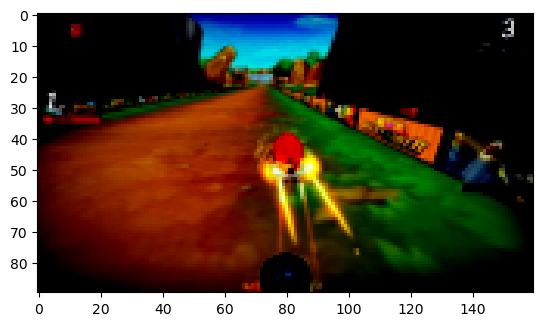

In [10]:
idx = -1

test = train_dataset[idx]
print(test[0].shape)
print(test[1])

plt.imshow(test[0][:, 0, :, :].swapaxes(0, 1).swapaxes(1, 2))

In [11]:
num_epochs = 10
lr = 1e-4
batch_size = 32
log_interval = 10

In [12]:
train_loader = data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    num_workers = 0,
    shuffle = True,
    drop_last = True
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size = 1,
    num_workers = 0,
    shuffle = False,
    drop_last = False
)

In [13]:
print(len(train_loader))
print(len(train_dataset))
print(len(val_loader))
print(len(val_dataset))

230
7369
847
847


In [14]:
num_classes = len(str_to_label)

class Cnn3DModel(nn.Module):
    def __init__(self):
        super(Cnn3DModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(3, 16)
        self.conv_layer2 = self._conv_layer_set(16, 32)
        self.conv_layer3 = self._conv_layer_set(32, 64)
        self.conv_layer4 = self._conv_layer_set(64, 128)
        self.fc1 = nn.Linear(3072, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, num_classes)
    
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size = (3, 3, 3), padding = (1, 0, 0)),
            nn.BatchNorm3d(num_features = out_c),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        
        return out

In [15]:
model = Cnn3DModel()
model = model.to(device)

print(model)

Cnn3DModel(
  (conv_layer1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 0, 0))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 0, 0))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 0, 0))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer4): Sequen

In [16]:
for param, weight in model.named_parameters():
    print(f"param {param:20} required gradient? -> {weight.requires_grad}")

param conv_layer1.0.weight required gradient? -> True
param conv_layer1.0.bias   required gradient? -> True
param conv_layer1.1.weight required gradient? -> True
param conv_layer1.1.bias   required gradient? -> True
param conv_layer2.0.weight required gradient? -> True
param conv_layer2.0.bias   required gradient? -> True
param conv_layer2.1.weight required gradient? -> True
param conv_layer2.1.bias   required gradient? -> True
param conv_layer3.0.weight required gradient? -> True
param conv_layer3.0.bias   required gradient? -> True
param conv_layer3.1.weight required gradient? -> True
param conv_layer3.1.bias   required gradient? -> True
param conv_layer4.0.weight required gradient? -> True
param conv_layer4.0.bias   required gradient? -> True
param conv_layer4.1.weight required gradient? -> True
param conv_layer4.1.bias   required gradient? -> True
param fc1.weight           required gradient? -> True
param fc1.bias             required gradient? -> True
param bn1.weight           r

In [17]:
print(label_counter)
normed_weights = [1 - (x / sum(label_counter)) for x in label_counter]
normed_weights = torch.FloatTensor(normed_weights).to(device)
print(normed_weights)

criterion = nn.CrossEntropyLoss(normed_weights)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = 5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max = 50)

[3901, 1599, 1408, 378, 63, 219, 227, 148, 109, 63, 32, 35, 34]
tensor([0.5252, 0.8054, 0.8286, 0.9540, 0.9923, 0.9733, 0.9724, 0.9820, 0.9867,
        0.9923, 0.9961, 0.9957, 0.9959], device='cuda:0')


In [18]:
it = iter(train_loader)
inputs, labels = next(it)
print("input shape : ", inputs.shape)
print("labels : ", labels)

inputs = inputs.to(device)
labels = labels.to(device)
outs = model(inputs)
print("out shape : ", outs.shape)
preds = torch.argmax(outs, dim = -1)
print("preds : ", preds)
print("labels : ", labels)

matches = (labels == preds).sum().item()

print("matches : ", matches)

loss = criterion(outs, labels)
print("loss cpu : ", loss.cpu())

input shape :  torch.Size([32, 3, 20, 90, 160])
labels :  tensor([0, 0, 2, 0, 0, 1, 2, 1, 9, 2, 0, 1, 2, 1, 0, 0, 5, 1, 0, 0, 1, 0, 0, 2,
        0, 1, 0, 0, 0, 0, 1, 0])
out shape :  torch.Size([32, 13])
preds :  tensor([ 5,  7,  0, 11,  7, 11,  0, 11,  5,  0,  9,  9,  1,  5,  9, 10,  6,  5,
         0,  5, 10,  7,  7, 10,  9, 10,  0,  6,  6,  5, 10,  7],
       device='cuda:0')
labels :  tensor([0, 0, 2, 0, 0, 1, 2, 1, 9, 2, 0, 1, 2, 1, 0, 0, 5, 1, 0, 0, 1, 0, 0, 2,
        0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
matches :  2
loss cpu :  tensor(2.7286, grad_fn=<ToCopyBackward0>)


In [19]:
for epoch in range(num_epochs):
    model.train()
    loss_val = 0
    matches = 0
    
    for idx, train_batch in enumerate(train_loader):
        inputs, labels = train_batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        outs = model(inputs)
        preds = torch.argmax(outs, dim = -1)
        loss = criterion(outs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_val += loss.item()
        matches += (labels == preds).sum().item()
        
        if (idx + 1) % log_interval == 0:
            train_loss = loss_val / log_interval
            train_acc = matches / batch_size / log_interval
            
            print(
                f"Epoch[{epoch + 1}/{num_epochs}]({idx + 1}/{len(train_loader)}) || "
                # f"training loss {train_loss:4.4} || lr {current_lr}"
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%}")

        loss_val = 0
        matches = 0
    
    model.eval()
    val_loss_val = 0
    val_matches = 0
    
    for idx, val_batch in enumerate(val_loader):
        inputs, labels = val_batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        outs = model(inputs)
        preds = torch.argmax(outs, dim = -1)
        loss = criterion(outs, labels)
        
        val_loss_val += loss.item()
        val_matches += (labels == preds).sum().item()
    
    current_lr = scheduler.get_last_lr()
    val_loss = val_loss_val / len(val_loader)
    val_acc = val_matches / len(val_loader)
    
    print(f"----- Epoch {epoch + 1} validation -----")
    print(f"validation loss {val_loss:4.4} || validation accuracy {val_acc:4.2%} || lr {current_lr}")
    print("---------------")
    
    torch.save(model.state_dict(), f"./weights/model2_epoch_{epoch}")
    
    scheduler.step()

Epoch[1/10](10/230) || training loss 0.1868 || training accuracy 4.69%
Epoch[1/10](20/230) || training loss 0.1462 || training accuracy 5.94%
Epoch[1/10](30/230) || training loss 0.1097 || training accuracy 7.50%
Epoch[1/10](40/230) || training loss 0.1228 || training accuracy 5.62%
Epoch[1/10](50/230) || training loss 0.1349 || training accuracy 5.94%
Epoch[1/10](60/230) || training loss 0.1238 || training accuracy 7.19%
Epoch[1/10](70/230) || training loss 0.1078 || training accuracy 7.19%
Epoch[1/10](80/230) || training loss 0.1157 || training accuracy 6.88%
Epoch[1/10](90/230) || training loss 0.1438 || training accuracy 5.94%
Epoch[1/10](100/230) || training loss 0.0926 || training accuracy 6.88%
Epoch[1/10](110/230) || training loss 0.1376 || training accuracy 4.69%
Epoch[1/10](120/230) || training loss 0.1235 || training accuracy 5.00%
Epoch[1/10](130/230) || training loss 0.1267 || training accuracy 6.25%
Epoch[1/10](140/230) || training loss 0.08965 || training accuracy 7.19%


Epoch[5/10](160/230) || training loss 0.03323 || training accuracy 8.75%
Epoch[5/10](170/230) || training loss 0.04834 || training accuracy 8.75%
Epoch[5/10](180/230) || training loss 0.05055 || training accuracy 8.44%
Epoch[5/10](190/230) || training loss 0.04209 || training accuracy 9.06%
Epoch[5/10](200/230) || training loss 0.06062 || training accuracy 7.81%
Epoch[5/10](210/230) || training loss 0.04711 || training accuracy 8.75%
Epoch[5/10](220/230) || training loss 0.06741 || training accuracy 7.50%
Epoch[5/10](230/230) || training loss 0.03514 || training accuracy 8.44%
----- Epoch 5 validation -----
validation loss 1.057 || validation accuracy 67.77% || lr [9.842915805643155e-05]
---------------
Epoch[6/10](10/230) || training loss 0.02032 || training accuracy 9.69%
Epoch[6/10](20/230) || training loss 0.03562 || training accuracy 8.75%
Epoch[6/10](30/230) || training loss 0.04549 || training accuracy 8.12%
Epoch[6/10](40/230) || training loss 0.02576 || training accuracy 9.06%

Epoch[10/10](40/230) || training loss 0.001053 || training accuracy 10.00%
Epoch[10/10](50/230) || training loss 0.00244 || training accuracy 10.00%
Epoch[10/10](60/230) || training loss 0.001635 || training accuracy 10.00%
Epoch[10/10](70/230) || training loss 0.001632 || training accuracy 10.00%
Epoch[10/10](80/230) || training loss 0.001473 || training accuracy 10.00%
Epoch[10/10](90/230) || training loss 0.005302 || training accuracy 9.69%
Epoch[10/10](100/230) || training loss 0.001498 || training accuracy 10.00%
Epoch[10/10](110/230) || training loss 0.001223 || training accuracy 10.00%
Epoch[10/10](120/230) || training loss 0.005207 || training accuracy 9.69%
Epoch[10/10](130/230) || training loss 0.002321 || training accuracy 10.00%
Epoch[10/10](140/230) || training loss 0.002864 || training accuracy 10.00%
Epoch[10/10](150/230) || training loss 0.00183 || training accuracy 10.00%
Epoch[10/10](160/230) || training loss 0.001412 || training accuracy 10.00%
Epoch[10/10](170/230) 

In [20]:
# save_path = "./weights/model2.pt"
# torch.save(model.state_dict(), save_path)